<a href="https://colab.research.google.com/github/juvana81/Parkinsons-Disease-Detection/blob/main/Parkinsons_detection_using_cnn_and_spiral_drawing_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()  # Select spiral drawing.zip when prompted

# After uploading
import zipfile
import io

with zipfile.ZipFile(io.BytesIO(uploaded['spiral drawing.zip']), 'r') as zip_ref:
    zip_ref.extractall('/content/')


Saving spiral drawing.zip to spiral drawing.zip


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam



In [ ]:
IMG_SIZE = 128
base_dir = '/content/spiral drawing'

def load_data(base_dir):
    data = []
    labels = []
    for category in ['healthy', 'parkinson']:
        label = 0 if category == 'healthy' else 1
        folder = os.path.join(base_dir, 'training', category)
        for filename in os.listdir(folder):
            try:
                img_path = os.path.join(folder, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                data.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    return np.array(data), np.array(labels)


In [ ]:
X, y = load_data(base_dir)
X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1) / 255.0
y = to_categorical(y)


divide the dataset into Train and test

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


Cnn model

In [ ]:
model = Sequential()

# Layer 1: Convolution + ReLU + Max Pooling
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))

# Layer 2: Convolution + ReLU + Max Pooling
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Layer 3: Convolution + ReLU + Max Pooling (optional but recommended)
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten and Dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))  # For 2 classes

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',  # use binary_crossentropy for sigmoid
              metrics=['accuracy'])

# Summary
model.summary()



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,322 (12.60 MB)

 Trainable params: 3,304,322 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

Prediction Function

In [ ]:
def predict_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = img.reshape(1, IMG_SIZE, IMG_SIZE, 1)
    prediction = model.predict(img)
    label = 'Parkinsons' if prediction[0][0] > 0.5 else 'Healthy'
    confidence = prediction[0][0] if prediction[0][0] > 0.5 else 1 - prediction[0][0]
    return label, confidence


In [ ]:
healthy_path = os.path.join(base_dir, 'testing', 'healthy', os.listdir(os.path.join(base_dir, 'testing', 'healthy'))[2])
parkinsons_path = os.path.join(base_dir, 'testing', 'parkinson', os.listdir(os.path.join(base_dir, 'testing', 'parkinson'))[0])

label_healthy, conf_healthy = predict_image(healthy_path)
img_healthy = cv2.imread(healthy_path, cv2.IMREAD_GRAYSCALE)

label_parkinsons, conf_parkinsons = predict_image(parkinsons_path)
img_parkinsons = cv2.imread(parkinsons_path, cv2.IMREAD_GRAYSCALE)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


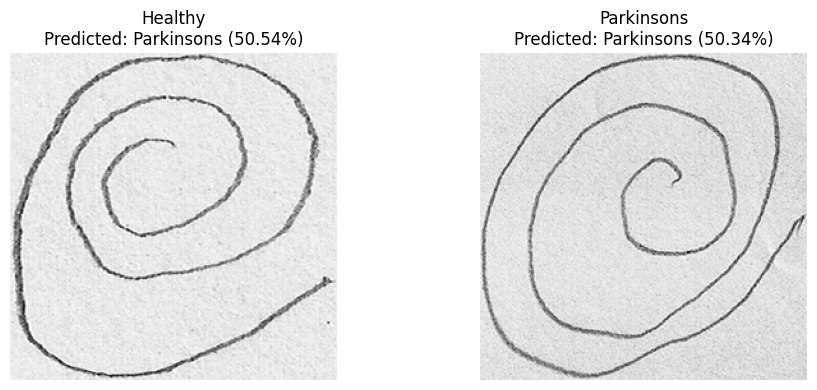

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_healthy, cmap='gray')
plt.title(f"Healthy\nPredicted: {label_healthy} ({conf_healthy*100:.2f}%)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_parkinsons, cmap='gray')
plt.title(f"Parkinsons\nPredicted: {label_parkinsons} ({conf_parkinsons*100:.2f}%)")
plt.axis('off')

plt.tight_layout()
plt.show()


In [25]:
from sklearn.model_selection import train_test_split

# Assuming X and y are defined
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:

y_true = np.argmax(y_test, axis=1)  # Assuming y_test is one-hot encoded
y_pred = np.argmax(y_pred_proba, axis=1)  # Assuming y_pred_proba contains probabilities

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_true, y_pred, target_names=["Healthy", "Parkinson's"])
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[9 1]
 [5 0]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.64      0.90      0.75        10
 Parkinson's       0.00      0.00      0.00         5

    accuracy                           0.60        15
   macro avg       0.32      0.45      0.38        15
weighted avg       0.43      0.60      0.50        15



Plot Confusion Matrix

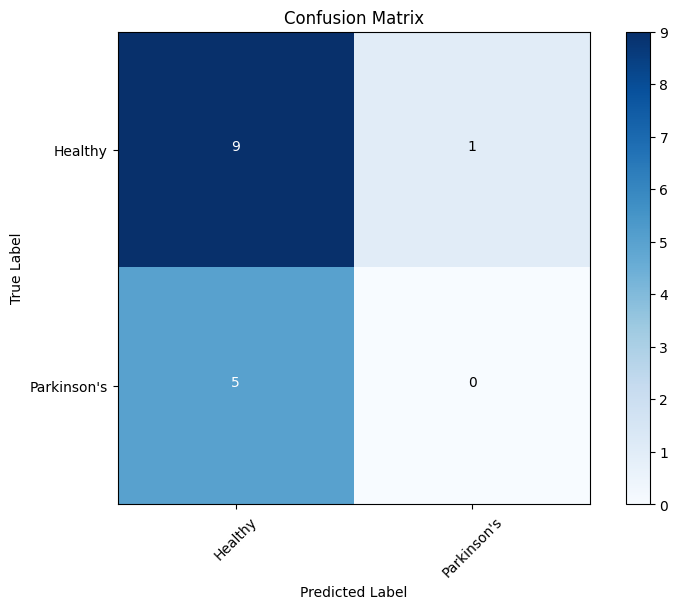

Binary Accuracy: 60.00%


In [38]:

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix, classes=["Healthy", "Parkinson's"])
plt.show()

# Example Metrics
binary_accuracy = np.sum(y_pred == y_true) / len(y_true)
print(f"Binary Accuracy: {binary_accuracy * 100:.2f}%")

